<a href="https://colab.research.google.com/github/santiric/heart-failure-prediction-via-clustering/blob/main/Heart_Failure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Riccardo Santi* - 2182525 - *Scienze Statistiche*



# **Heart Failure Prediction Dataset, but we don't know many of the labels**

The *Heart Failure Prediction Dataset* is a well-known Kaggle dataset commonly used as a benchmark for binary classification. In this work, we pursue the same predictive goal but without relying on the provided labels, thereby framing the task as an unsupervised learning problem. We'll use clustering methods to do so.

We will assume to only know very few labels after performing the cluster, all the other one will be unknown.

Citation of the dataset: fedesoriano. (September 2021). Heart Failure Prediction Dataset. Retrieved [Date Retrieved] from https://www.kaggle.com/fedesoriano/heart-failure-prediction.

**Getting the dataset via Kaggle**

**Step 1**: Install the Kaggle API

In [ ]:
!pip install -q kagglehub

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("fedesoriano/heart-failure-prediction")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'heart-failure-prediction' dataset.
Path to dataset files: /kaggle/input/heart-failure-prediction


In [ ]:
import os
import pandas as pd

# List files in the downloaded directory
print(os.listdir(path))

# Load the CSV file (there should be only one)
csv_path = os.path.join(path, "heart.csv")
df = pd.read_csv(csv_path)

# Inspect the data
print(df.head())
print(df.info())
print(df.describe())



['heart.csv']
   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  ----- 

**A description of the dataset**

*Context*

Cardiovascular diseases (CVDs) are the number 1 cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 31% of all deaths worldwide. Four out of 5CVD deaths are due to heart attacks and strokes, and one-third of these deaths occur prematurely in people under 70 years of age. Heart failure is a common event caused by CVDs and this dataset contains 11 features that can be used to predict a possible heart disease.

People with cardiovascular disease or who are at high cardiovascular risk (due to the presence of one or more risk factors such as hypertension, diabetes, hyperlipidaemia or already established disease) need early detection and management wherein a machine learning model can be of great help.

*Attribute Information*

 - Age: age of the patient [years]
 - Sex: sex of the patient [M: Male, F: Female]
 - ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
 - RestingBP: resting blood pressure [mm Hg]
 - Cholesterol: serum cholesterol [mm/dl]
 - FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
 - RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
 - MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
 - ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
 - Oldpeak: oldpeak = ST [Numeric value measured in depression]
 - ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
 - HeartDisease: output class [1: heart disease, 0: Normal]

**The data**

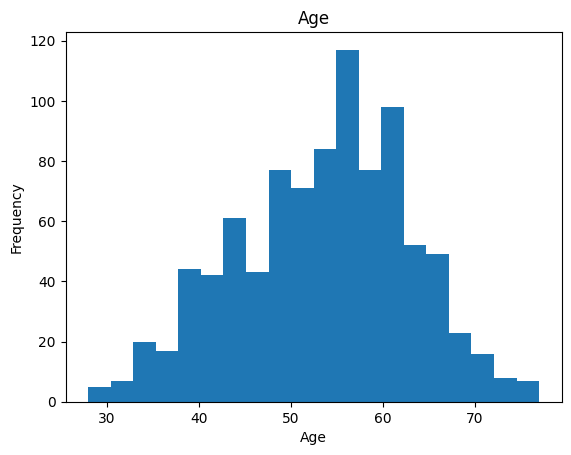

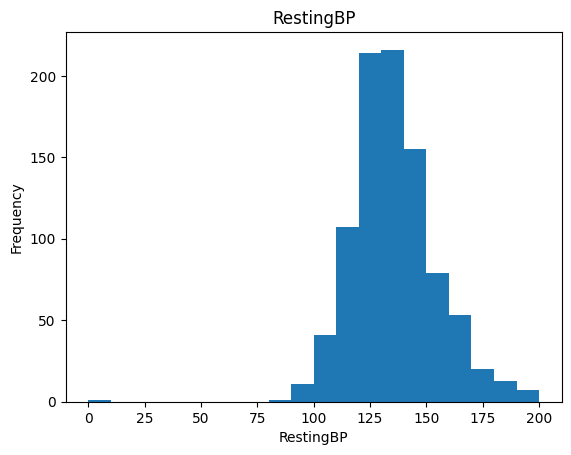

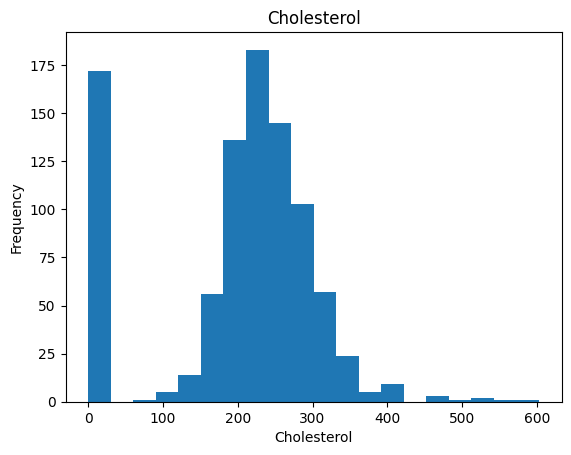

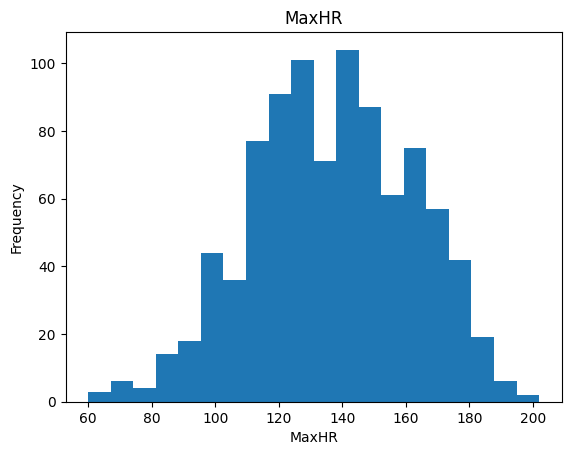

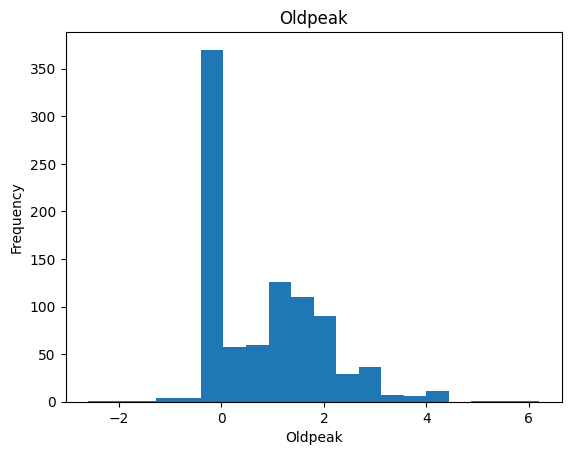

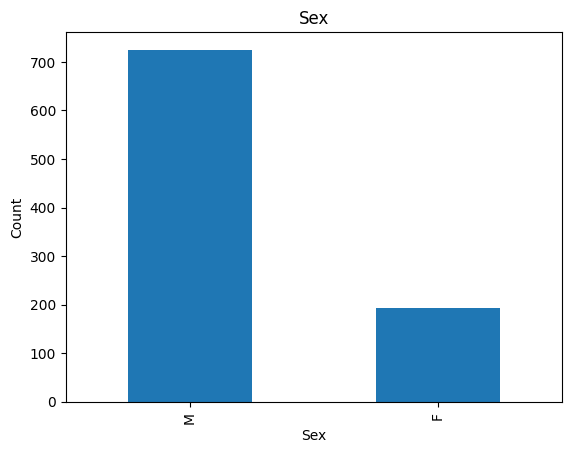

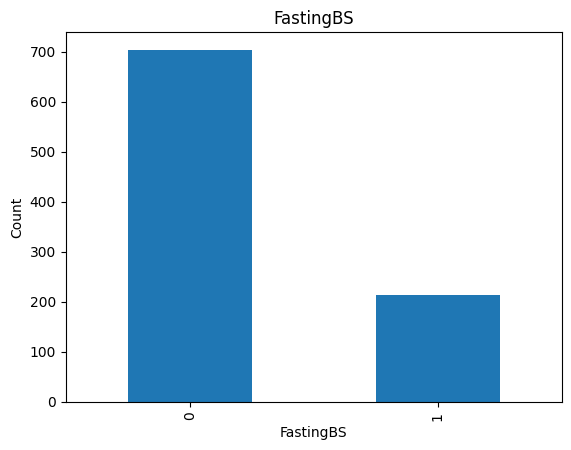

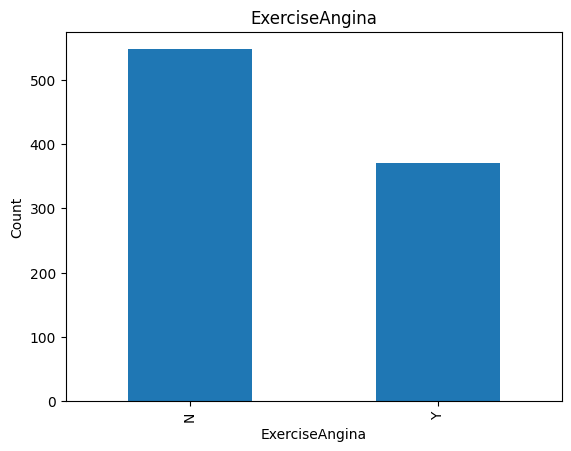

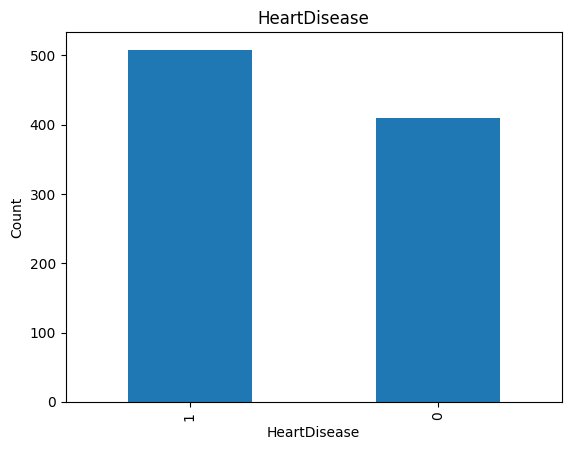

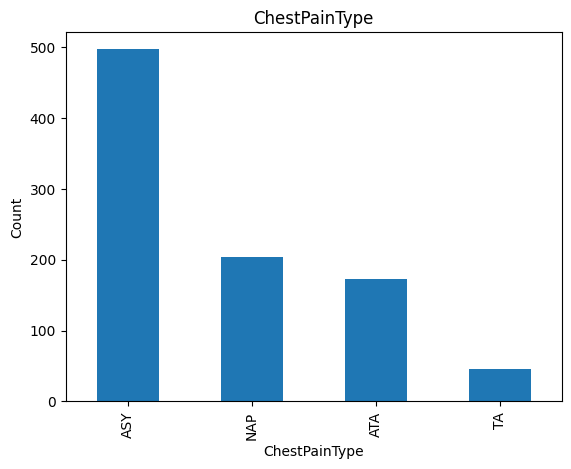

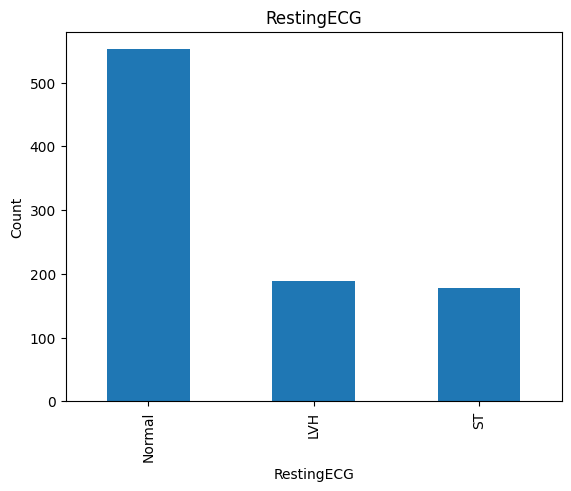

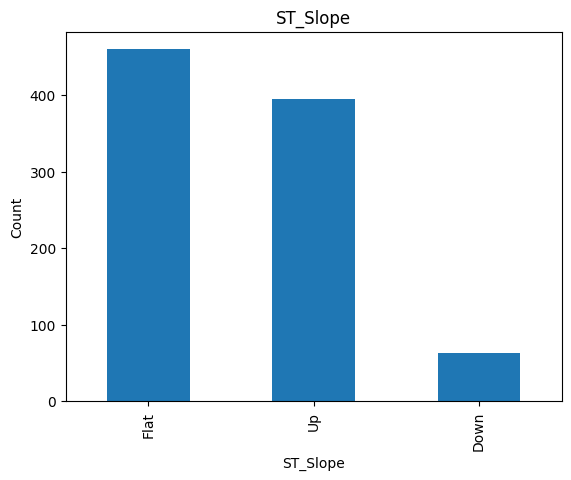

In [ ]:
import matplotlib.pyplot as plt
# ---- NUMERIC VARIABLES ----
numeric_vars = [
    "Age",
    "RestingBP",
    "Cholesterol",
    "MaxHR",
    "Oldpeak"
]

for col in numeric_vars:
    plt.figure()
    plt.hist(df[col], bins=20)
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

# ---- BINARY VARIABLES ----
binary_vars = [
    "Sex",
    "FastingBS",
    "ExerciseAngina",
    "HeartDisease"
]

for col in binary_vars:
    plt.figure()
    df[col].value_counts().plot(kind="bar")
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

# ---- CATEGORICAL (MULTI-CLASS) VARIABLES ----
categorical_vars = [
    "ChestPainType",
    "RestingECG",
    "ST_Slope"
]

for col in categorical_vars:
    plt.figure()
    df[col].value_counts().plot(kind="bar")
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

Strong collinearity might harm our clustering methods because redundant data might assign more weight to the same conceptual information, potentially biasing the formation of clusters, exaggerating the influence of correlated features, and obscuring the true underlying structure of the data. This can lead to clusters that reflect redundancy rather than meaningful differences.


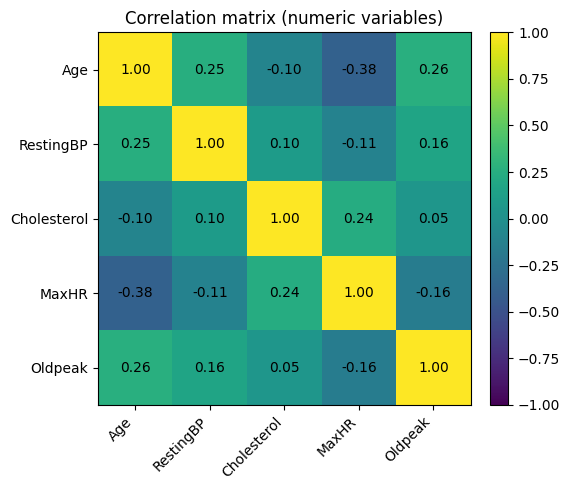

In [ ]:
# Correlation matrix
corr = df[numeric_vars].corr()

# Corrplot (heatmap)
plt.figure(figsize=(6, 5))
im = plt.imshow(corr, vmin=-1, vmax=1)

plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(numeric_vars)), numeric_vars, rotation=45, ha="right")
plt.yticks(range(len(numeric_vars)), numeric_vars)

# Annotate values
for i in range(len(numeric_vars)):
    for j in range(len(numeric_vars)):
        plt.text(j, i, f"{corr.iloc[i, j]:.2f}",
                 ha="center", va="center")

plt.title("Correlation matrix (numeric variables)")
plt.tight_layout()
plt.show()

There are some numerical variable that are correlated, but nothing to strong to worry about.

**Clustering**

In our dataset, we have both **qualitative (categorical)** and **numeric (quantitative)** variables.  
To properly measure dissimilarities between observations that include mixed data types, we use the **Gower distance**.

Gower defines a **similarity measure** for each variable type:  
- For numeric variables, the similarity is computed as the scaled absolute difference.  
- For categorical variables, the similarity is 1 if the values are equal and 0 if they are different.  

The overall **Gower distance** between two observations is then defined as one minus the average of these per-variable similarities, allowing us to combine qualitative and quantitative information into a single (pseudo) **distance measure**.

More formally, the distance between observations \(x\) and \(y\) is:

$$
d_{\text{Gower}}(x, y) = 1 - \frac{\sum_{i=1}^{p} w_i s_i(x_i, y_i)}{\sum_{i=1}^{p} w_i}
$$

Where:  
- $p$ = Number of features  
- $s_i(x_i, y_i)$ = Similarity between $x_i$ and $y_i$ for feature $i$  
- $w_i$ = Weight indicating whether the comparison is valid (e.g., both values are non-missing) (we don't have any missing values in our application) .

**Similarity Measures:**  

1. **Numerical Features**: Scaled absolute difference  

$$
s_i(x_i, y_i) = 1 - \frac{|x_i - y_i|}{R_i}
$$

where $R_i$ is the range of feature $i$.  

2. **Categorical Features**: Binary similarity  

$$
s_i(x_i, y_i) =
\begin{cases}
1 & \text{if } x_i = y_i \\[1mm]
0 & \text{otherwise}
\end{cases}
$$

This formulation ensures that **both numeric and categorical variables contribute appropriately** to the overall dissimilarity between observations.



We now apply Agglomerative Hierarchical Clustering on the dataset, employing the Gower distance as the dissimilarity measure and average linkage to define cluster proximity.

In [ ]:
print(df.dtypes) #we need the correct ver types to calculate the distance

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object


In [ ]:
# Install the Gower package if not already installed
!pip install gower

/tmp/ipython-input-95881317.py:15: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(gower_dist, method='average')


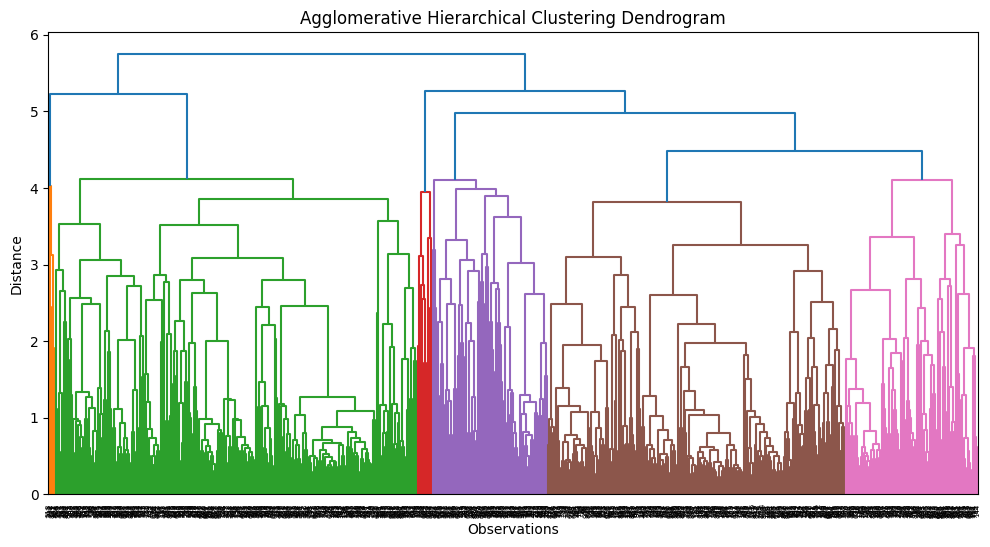

In [ ]:
import gower
import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Suppose your dataset is in df and the target variable is "target"
y = df['HeartDisease']  # Store the variable to be removed
X = df.drop(columns=['HeartDisease'])  # Remove it from the features used for clustering

# Compute the Gower distance matrix
# gower.gower_matrix automatically handles numeric and categorical variables based on dtype
gower_dist = gower.gower_matrix(X)

# Perform Agglomerative Hierarchical Clustering with average linkage
Z = linkage(gower_dist, method='average')

# Plot the dendrogram
plt.figure(figsize=(12, 6))
dendrogram(Z, labels=X.index, leaf_rotation=90,color_threshold=4.2)
plt.title("Agglomerative Hierarchical Clustering Dendrogram")
plt.xlabel("Observations")
plt.ylabel("Distance")
plt.show()


One might be tempted to choose just two clusters, since the original dataset has two labels. However, this approach can be problematic if the predictors do not have monotonic relationships with the outcome. For example, both extremely low and extremely high blood pressure could be indicative of heart disease, yet these two situations are far apart in the feature space. Using only two clusters might place them in opposite groups. I chosed what I think to be a decent clustering according to the distances in the dendogram.

In [ ]:
from scipy.cluster.hierarchy import fcluster

# Cut the dendrogram at distance threshold 4.2
threshold =4.2
cluster_labels = fcluster(Z, t=threshold, criterion='distance')

# Add the cluster labels to your DataFrame
X['cluster'] = cluster_labels

# Optional: check how many observations are in each cluster
print(X['cluster'].value_counts())

cluster
2    358
5    294
6    131
4    114
3     14
1      7
Name: count, dtype: int64


Now, suppose we only have a very small number of labeled observations — too few to treat this as a standard supervised classification problem, but still containing potentially useful information. Let’s assume we have 11 labeled points. This is not an arbitrary number: with so few labels, it is literally impossible to estimate even a simple generalized linear model, because the regressor matrix has not full rank — the number of regressors equals the number of observations.



Let's use the information provided by these labels to decide which label assign to every cluster.

In [ ]:
import numpy as np
import pandas as pd

# Suppose X['cluster'] already exists from hierarchical clustering
# Randomly pick 11 indices to keep as labeled
np.random.seed(1)  # for reproducibility
labeled_indices = np.random.choice(X.index, size=11, replace=False)

# Create a new column with mostly NaN, only 11 labels known
y_limited = pd.Series(data=np.nan, index=X.index)
y_limited[labeled_indices] = y[labeled_indices]

# Compute mode of y for each cluster using only the labeled points
cluster_y_mode = y_limited.groupby(X['cluster']).agg(lambda x: x.mode()[0] if x.notna().any() else np.nan)

print(cluster_y_mode)

cluster
1    NaN
2    1.0
3    NaN
4    1.0
5    0.0
6    0.0
dtype: float64


We assign the label 1 (heart disease) to clusters 2 and 4. And the label 0 (no heart disease) to 5 and 6. We don't have informations for clusters 1 and 3. Looking at the dendogram we see that cluster 1 is more similar to cluster 2, so we label it with 1. Cluster 3 is more similar to the collection of clusters {4,5,6} , that is dominated by 5 and 6, so we label cluster 3 with 0.

Now let's see, using all the true labels, how well our technique performed.

In [ ]:
# Compute mean of the target variable y per cluster (in this metric are also present the labels we assumed to know,
#but they are too few to even bother removing them)
y_rep = y.groupby(X['cluster']).mean()
our_prediction = pd.Series([1, 1, 0, 1, 0, 0], index=y_rep.index, name='our prediction')
table = pd.concat([y_rep.rename('y_rep'), our_prediction], axis=1)

print(table)



            y_rep  our prediction
cluster                          
1        1.000000               1
2        0.860335               1
3        0.071429               0
4        0.710526               1
5        0.098639               0
6        0.625954               0


The table show the actual proportion of people with heart disease in every cluster we found. It seems we did pretty good.

Lets' calculate a couple of other metrics:

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
import pandas as pd

# Cluster-level labels (cluster 1 -> 1, cluster 2 -> 1, etc.)
cluster_labels_map = {
    1: 1,
    2: 1,
    3: 0,
    4: 1,
    5: 0,
    6: 0
}

# Assign predicted label to each observation based on its cluster
y_pred = X['cluster'].map(cluster_labels_map)

# Compute metrics
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)

print(f"Accuracy:  {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")


Accuracy:  0.788
Precision: 0.827
Recall:    0.780


The model perform quite good (consider that the classes are quite balanced for consideration about the metrics).